Link if people prefer Google Colab Notebook: https://colab.research.google.com/drive/1_Z1RehijDeqJ6fZzOaHGQCeSsamxWxhX 

# Section 1: Call center data modeling

You are advising a client on the number of call center agents they need to handle their customer support load. We start by modeling the number of phone calls we expect to come into the call center during each hour of the day.

You are provided with a data set of the intervals between phone calls arriving during one day. Each value is a time in minutes indicating the amount of time that passed between receiving two consecutive phone calls.

## Loading and initializing the data

In [0]:
# importing packages

import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('https://docs.google.com/spreadsheets/d/e/2PACX-1vTDuQCIYts48eH8mNrw60_c5H0cjRzhwxD2OLveOaN5DnelQ99s22oU2rzRyLS0Oh1iNlEatp68fdmv/pub?gid=485723753&single=true&output=csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


In [3]:
number_call = [len(waiting_time_hour) for waiting_time_hour in waiting_times_per_hour]
print("Percentage of calls between 8 AM and 8 PM: ",
      np.sum(number_call[8:21])/np.sum(number_call))

Percentage of calls between 8 AM and 8 PM:  0.922301912568306


## 1. Building important functions

1. The **likelihood** function, which is P(datum | lambda_), and this likelihood follow an exponential distribution: the exponential distribution of the datum given the parameter value
2. The **prior** function, which is P(lambda_), and this likelihood follow a Gamma distribution: the distribution Gamma(λ | α, β).
3. The **compute_posterior** function, which uses Bayes' Theorem.
4. The **compute_percentile** function, which compute the parameter value at a particular percentile of the given probability distribution values.

In [0]:
# THE LIKELIHOOD FUNCTION
#
# This function takes 2 inputs, namely the parameter (λ) value at which to
# compute the likelihood and a value from the data set. You need to evaluate
# the exponential distribution of the datum given the parameter value.
#np.array([np.sum(np.log(likelihood(param, data))) for param in parameter_values])
def likelihood(lambda_, datum):
    return sts.expon(scale=1/lambda_).pdf(datum)

#####################################################
# THE PRIOR DISTRIBUTION
#
# This function takes 1 input, namely the parameter value (λ) at which to
# compute the prior probability density. You need to evaluate the distribution
# Gamma(λ | α, β).

def prior(lambda_):
    return sts.gamma(1, scale=1/0.25).pdf(lambda_)

#####################################################
# THE POSTERIOR DISTRIBUTION: T
#
# The function below is provided to help make computing the posterior easier. It
# follows the same pattern as in the previous class, where we multiple the prior
# and the likelihood evaluated at various values of the parameter (λ).
#
# You will see the function uses the logarithms of various distributions. This
# is for numerical reasons. When you multiply lots of likelihood values, the
# result can become very large or very small, causing numerical overflow or
# underflow in Python. Taking logarithms avoids this problem.
def compute_posterior(parameter_values, data):
    # Notes: The detail of this function will be presented in Section 2 
    # (stretch goal: problem 2)
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([np.sum(np.log(likelihood(param, data))) for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

#####################################################
# THE PERCENTILE FUNCTION
 
# Compute the parameter value at a particular percentile of the given
# probability distribution values. This function uses the cumulative trapezoid
# integrator in SciPy.
#
# Inputs:
#
# parameter_values (array of float) This is the list of parameter values
# at which the probability distribution has been evaluated.
#
# distribution_values (array of float) This is the list of values of the
# probability density function evaluated at the parameter values above.
# 
# percentile (float) This is the value between 0 and 1 of the percentile 
# to compute.
#
# Returns: (float) The parameter value at the given percentile.
def compute_percentile(parameter_values, distribution_values, percentile):
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

## 2. Compute and Visualize the results

1. Compute a 98% posterior confidence interval over the number of calls per minute for every hour of the day: 24 intervals total
2. Compute the posterior mean of λ for each hour of the day
3. Visualize the results above using an errorbar() plot: Each dot is at the posterior mean and each line shows a 98% confidence interval for a λ

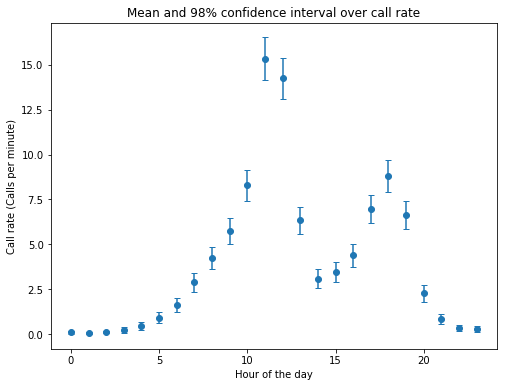

In [5]:
# Create empty lists for storing the data
#
# upper_percentiles_diff to store the difference between the 99% 
# and the posterior mean
#
# lower_percentiles_diff to store the difference between the 01% 
# and the posterior mean
#
# lambda_ to store the posterior mean
upper_percentiles_diff = []
lower_percentiles_diff = []
lambda_ = []

# iterate through every hour in the 24 hours series data
for waiting_times_hour in  waiting_times_per_hour:
    # initialize the lambdas values
    lambdas = np.linspace(0, 20, 501)[1:]
    #
    # compute the posterior by using the compute_posterior function
    # with the initialized lambdas and the data (of each hour)
    posterior = compute_posterior(lambdas, waiting_times_hour)
    #
    # Add the newly calculated posterior mean to the lambda_ list
    lambda_.append(sp.integrate.trapz(posterior * lambdas, lambdas))
    #
    # Calculate the difference between the posterior mean with the 99% percentile
    # and append to the upper_percentiles_diff list
    upper_percentiles_diff.append(compute_percentile(lambdas, posterior, 0.99) - lambda_[-1])
    #
    # Calculate the difference between the posterior mean with the 1% percentile
    # and append to the upper_percentiles_diff list
    lower_percentiles_diff.append(lambda_[-1] - compute_percentile(lambdas, posterior, 0.01))

# initialize the graph
plt.figure(figsize=(8, 6))
# plot the error bar with the mean at lambda_ and the range from the mean derives
# from the upper_percentiles_diff and lower_percentiles_diff
plt.errorbar(list(range(24)), lambda_, yerr = [upper_percentiles_diff,lower_percentiles_diff]
             , fmt="o", capsize=3)
# label the axes and plot
plt.ylabel('Call rate (Calls per minute)')
plt.xlabel('Hour of the day')
plt.title('Mean and 98% confidence interval over call rate')
plt.show()

## 3. Summarized Findings

The number of calls per minute in each hour increases exponentially from midnight and peaks at 11 AM. The calls rates decrease until 2 PM and start increases again, peaks at 6 PM. After 6 PM, the calls rates decrease exponentially. 


Starting from 11 AM to noon, the average calls rate per minute is 15.4 calls, with 98% in $\pm$ 1.2 calls interval. At noon, the average calls rate per minute is also high, at 14.3 calls, with 98% in $\pm$ 1.1 calls interval
Another local mode is at 6 PM, where the average calls rate is 8.8 calls, with 98% in $\pm$ 0.9 calls interval. Based on the data, 92.2% of the number of calls happened between 8 AM to 8 PM. 


Business action items: The company should arrange more employees at noon (from 11 AM till 1 PM), with the average 12.8 calls, and at 6 PM, with an average of 8.8 calls. Busy hours are between 8 AM and 8 PM, which might require additional staffs than other periods. More data needs to be collected (call duration, etc.) if we want to have an accurate estimate of how much time each employee respond to a phone call.  

$\pm$

# Section 2: Stretch goal
Explained the **compute_posterior** function.

In [0]:
def compute_posterior(parameter_values, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
                               np.sum(np.log(likelihood(param, data))) 
                               for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

## 1. How is the function multiply the prior and likelihood using logarithms

As we know: $$posterior = prior * likelihood$$

We have: 
1. prior is $Gamma(λ | α, β)$
2. likelihood is $P(datum | λ)$

If given more data (assuming all the data points are independent: which is a valid claim because a call from 1 customer will not likely to affect other customers' calls).

Then, with $n$ data points
$${posterior = prior * P(datum_1 | λ) * P(datum_2 | λ) * ... * P(datum_n | λ)}$$
$$$$
$$\Rightarrow \ln(posterior) = \ln(prior * P(datum_1 | λ) * P(datum_2 | λ) * ... * P(datum_n | λ))$$
$$$$
$$\Rightarrow \ln(posterior) = \ln(prior) + \ln(P(datum_1 | λ)) + \ln(P(datum_2 | λ)) + ... + \ln(P(datum_n | λ))$$
$$$$
$$\Rightarrow \ln(posterior) = \ln(prior) + \sum_{i=1}^{n} \ln(P(datum_i | λ))$$


Hence, the log of the posterior equals to sum of the log of the prior and the series of likelihood. This is demonstrated in the code where **unnormalized_log_posterior = log_prior + log_likelihood**. 

Where the **log_likelihood** variable is already a sum of all log of each datum likelihood by using **np.sum** above. 


In [0]:
def compute_posterior(parameter_values, data):
    # take the log of the prior
    log_prior = np.log(prior(parameter_values))
    
    # for each lambda (parameter_values), we compute the sum of all of log of
    # each datum likelihood by using np.sum
    log_likelihood = np.array([np.sum(np.log(likelihood(param, data))) for param in parameter_values])
    
    # the log of posterior is the sum of log of prior and log of likelihood
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

## 2. The purpose of np.sum() in line 4

The np.sum takes the sum of all values within an array. In line 4, it is computing $\sum_{i=1}^{n} \ln(P(datum_i | λ))$ with $n$ is the number of data points. For each lambda, we compute the sum of the likelihood of each datum given that lambda value.

## 3. The purpose of the maximum of the unnormalized log posterior is subtracted in line 7

If we don't subtract the max, in some real-life cases, the maximum will be too big, which makes line 8 occurs Warning like **overflow encountered in exp** 

(as Python cannot fully represents np.exp(x) as x is too big and occur numerical overflow - if x > 710, this warning will occur).

Subtracting will make the largest value in the posterior to be 0 and others values got smaller -> avoid numerical overflow for extremely big numbers. 

The act of subtracting the max in line 7 does not affect the visualization/intervals at all as we are just simply rescaling an additional step by dividing by a constant factor (subtract for log functions is dividing for after ward functions).

This is a pratical step to avoid Python numerical overflow error.

Example: Given the same dataset, we modify the code to see the warning. The warning occurs, which makes some values will be represented as **inf**. Then, these values are unprocessable, which lead to another error **invalid value encountered in true_divide**. This will create missing values at some intervals.  

As we can see from the code below, at hour[11], the value got too big, lead to overflow. Then, if we look at the graph, the values for hour = 11 does not exist. This cause the figure to be incorrect. Hence, subtracting the max is the practical move. 

0
1
2
3
4
5
6
7
8
9
10
11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


12
13
14
15
16
17
18
19
20
21
22
23


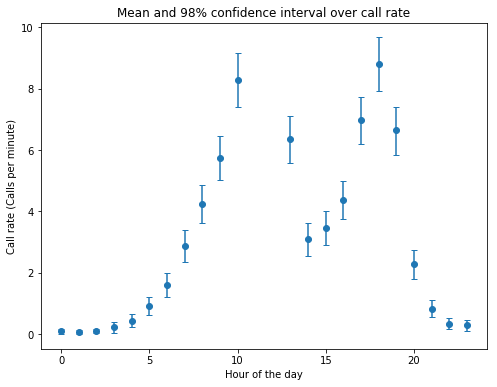

In [8]:
def compute_posterior(parameter_values, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
                               np.sum(np.log(likelihood(param, data))) 
                               for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    #unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

# Create empty lists for storing the data
#
# upper_percentiles_diff to store the difference between the 99% 
# and the posterior mean
#
# lower_percentiles_diff to store the difference between the 01% 
# and the posterior mean
#
# lambda_ to store the posterior mean
upper_percentiles_diff = []
lower_percentiles_diff = []
lambda_ = []

for i, waiting_times_hour in  enumerate(waiting_times_per_hour):
    print(i)
    # initialize the lambdas values
    lambdas = np.linspace(0, 20, 501)[1:]
    #
    # compute the posterior by using the compute_posterior function
    # with the initialized lambdas and the data (of each hour)
    posterior = compute_posterior(lambdas, waiting_times_hour)
    #
    # Add the newly calculated posterior mean to the lambda_ list
    lambda_.append(sp.integrate.trapz(posterior * lambdas, lambdas))
    #
    # Calculate the difference between the posterior mean with the 99% percentile
    # and append to the upper_percentiles_diff list
    upper_percentiles_diff.append(compute_percentile(lambdas, posterior, 0.99) - lambda_[-1])
    #
    # Calculate the difference between the posterior mean with the 1% percentile
    # and append to the upper_percentiles_diff list
    lower_percentiles_diff.append(lambda_[-1] - compute_percentile(lambdas, posterior, 0.01))

# initialize the graph
plt.figure(figsize=(8, 6))
# plot the error bar with the mean at lambda_ and the range from the mean derives
# from the upper_percentiles_diff and lower_percentiles_diff
plt.errorbar(list(range(24)), lambda_, yerr = [upper_percentiles_diff,lower_percentiles_diff]
             , fmt="o", capsize=3)
# label the axes and plot
plt.ylabel('Call rate (Calls per minute)')
plt.xlabel('Hour of the day')
plt.title('Mean and 98% confidence interval over call rate')
plt.show()

## 4. The purpose of dividing by the area in line 10 even after having subtracted the maximum of the unnormalized log posterior in line 7

The area under the curve has to be 1. Hence, we divide by the area. 

Subtracting the maximum of the unnormalized log posterior is simply a rescaling method to ensure computation efficiency and accuracy, but does not link anything with the condition $area = 1$. Therefore, we still have to divide the area at the end. 

In [0]:
def compute_posterior(parameter_values, data):
    # take the log of the prior
    log_prior = np.log(prior(parameter_values))
    
    # for each lambda (parameter_values), we compute the sum of all of log of
    # each datum likelihood by using np.sum
    log_likelihood = np.array([np.sum(np.log(likelihood(param, data))) for param in parameter_values])
    
    # the log of posterior is the sum of log of prior and log of likelihood
    unnormalized_log_posterior = log_prior + log_likelihood

    # rescaling to ensure no numerical overflow occurs. 
    unnormalized_log_posterior -= max(unnormalized_log_posterior)

    # as we are using log value the whole time, we now 
    # convert back to the original values.
    unnormalized_posterior = np.exp(unnormalized_log_posterior)

    # compute the area under the curve and divide the unnormalized_posterior
    # by the area to ensure area under the curve = 1 
    # 
    # (the -= max calculation above is an additional rescaling step to ensure
    # computation efficiency and accuracy and avoid numerical overflow, and 
    # does not have anything relate to area under the curve = 1)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

## 5. Create an example where not taking logarithms would cause a problem. 
Create a prior, likelihood, and data set that fails to produce the correct posterior when we don’t take logs. Show all your code and visualize your results on one or more plots.


Not taking the log would possibly face the same problem: numerical overflow.

Instead of taking log and take the sum, we then have to compute: $\prod_{i=1}^{n} P(datum_i|λ)$. 

For 5856 data points given, the product of all the likelihood of the datum given the parameter can exceed the numpy numeric memory (numerical overflow). Hence, causing warnings and inaccuracies. 

Therefore, it's a better practice to take the log and take the sum as it will less likely to be numerical overflow. 

Example: Given the same dataset, we modify the code (not using log) to see the warning.  The warning occurs, which makes some values will be represented as **inf**. Then, these values are unprocessable, which lead to another error **invalid value encountered in true_divide**. This will create missing values at some intervals.  

As we can see from the code below, at hour[11], the value got too big, lead to overflow. Then, if we look at the graph, the values for hour = 11 does not exist. This cause the figure to be incorrect. Hence, taking the log is the practical move. Also, we can see the graph is similar to Section 2, part 3: both graphs got missing values at hour[11] due to numerical overflow

0
1
2
3
4
5
6
7
8
9
10
11


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


12
13
14
15
16
17
18
19
20
21
22
23


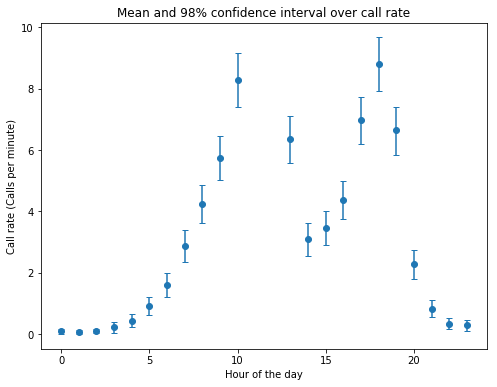

In [10]:
def compute_posterior(parameter_values, data):
    priors = prior(parameter_values)
    likelihoods = np.array([np.prod(likelihood(param, data)) for param in parameter_values])
    unnormalized_posterior = priors * likelihoods
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

# Create empty lists for storing the data
#
# upper_percentiles_diff to store the difference between the 99% 
# and the posterior mean
#
# lower_percentiles_diff to store the difference between the 01% 
# and the posterior mean
#
# lambda_ to store the posterior mean
upper_percentiles_diff = []
lower_percentiles_diff = []
lambda_ = []

for i, waiting_times_hour in  enumerate(waiting_times_per_hour):
    print(i)
    # initialize the lambdas values
    lambdas = np.linspace(0, 20, 501)[1:]
    #
    # compute the posterior by using the compute_posterior function
    # with the initialized lambdas and the data (of each hour)
    posterior = compute_posterior(lambdas, waiting_times_hour)
    #
    # Add the newly calculated posterior mean to the lambda_ list
    lambda_.append(sp.integrate.trapz(posterior * lambdas, lambdas))
    #
    # Calculate the difference between the posterior mean with the 99% percentile
    # and append to the upper_percentiles_diff list
    upper_percentiles_diff.append(compute_percentile(lambdas, posterior, 0.99) - lambda_[-1])
    #
    # Calculate the difference between the posterior mean with the 1% percentile
    # and append to the upper_percentiles_diff list
    lower_percentiles_diff.append(lambda_[-1] - compute_percentile(lambdas, posterior, 0.01))

# initialize the graph
plt.figure(figsize=(8, 6))
# plot the error bar with the mean at lambda_ and the range from the mean derives
# from the upper_percentiles_diff and lower_percentiles_diff
plt.errorbar(list(range(24)), lambda_, yerr = [upper_percentiles_diff,lower_percentiles_diff]
             , fmt="o", capsize=3)
# label the axes and plot
plt.ylabel('Call rate (Calls per minute)')
plt.xlabel('Hour of the day')
plt.title('Mean and 98% confidence interval over call rate')
plt.show()